In [ ]:
import scipy.io as sio
import numpy as np
import mat73
import center_algorithms as ca
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
from sklearn.manifold import MDS


In [2]:
n_its= 10
seed = 0

labels_raw = sio.loadmat('./data/kmeans_action_labels.mat')['kmeans_action_labels']

labels_true = [l[0][0] for l in labels_raw['labels'][0][0]]
# labelidxs =labels_raw['labelidxs'][0][0][0]


raw_data = mat73.loadmat('./data/kmeans_pts.mat')

X = [t[0] for t in raw_data['Data']['gr_pts']]

print(len(X))
X[0].shape



601


(1024, 48)

In [3]:
label_counts = {}
for l in labels_true:
    label_counts[l] = len(np.where(np.array(labels_true) == l)[0])
label_counts

{'push-cart': 20,
 'clap-group': 41,
 'ride-bike': 17,
 'swing': 3,
 'follow': 32,
 'flap': 11,
 'loiter': 185,
 'bend': 27,
 'run': 24,
 'point-group': 33,
 'cart-motion': 9,
 'stand': 5,
 'pickup': 27,
 'gesture': 39,
 'run-group': 4,
 'walk-rifle': 7,
 'loiter-group': 117}

In [4]:
idx = []
for the_labels in ['run', 'pickup', 'bend','follow', 'ride-bike']:
# for the_labels in ['run', 'stand', 'pickup']:
# for the_labels in ['run', 'stand', 'walk-rifle']: #for winning sine median
    idx += list(np.where(np.array(labels_true) == the_labels)[0])

In [5]:
labels_true = [labels_true[i] for i in idx]
X = [X[i] for i in idx]
labels_true

['run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'fo

In [6]:
# #synthetic test
# def distance_matrix(X, C, opt_type = 'sine'):
#     n = len(X)
#     m = len(C)
#     Distances = np.zeros((m, n))
#     for i in range(m):
#         for j in range(n):
#             Distances[i,j] = np.linalg.norm(C[i]-X[j])
#     return Distances

# X = []
# for i in range(10):
#     X.append(np.array([np.random.uniform(0, .5), np.random.uniform(0, .5)]))
#     X.append(np.array([np.random.uniform(1, 1.5), np.random.uniform(1, 1.5)]))
    
# for x in X:
#     plt.scatter(x[0],x[1], color = 'b')

# for x in X:
#     plt.scatter(x[0],x[1], color = 'b')
# for c in centers:
#     plt.scatter(c[0],c[1], color = 'y')

In [7]:

'''
datapoints rows and centers columns

sine
cosine
sine_sq
'''
def distance_matrix(X, C, opt_type = 'sine'):
    n = len(X)
    m = len(C)
    Distances = np.zeros((m,n))

    # if opt_type == 'cosine':
    #     opt_type = 'sinesq'

    for i in range(m):
        for j in range(n):
            Distances[i,j] = ca.calc_error_1_2([C[i]], X[j], 'sine')
            
    return Distances

def cluster_purity(X, centers, opt_type, labels_true):
    #calculate distance matrix
    d_mat = distance_matrix(X, centers, opt_type)

    #find the closest center for each point
    index = np.argmin(d_mat, axis = 0)
    
    count = 0
    for i in range(len(centers)):
        idx = np.where(index == i)[0]
        cluster_labels = [labels_true[i] for i in idx]
        most_common_label = max(set(cluster_labels), key = cluster_labels.count)
        # count += cluster_labels.count(most_common_label)
        count += cluster_labels.count(most_common_label)/len(idx)

    # return count/len(X)
    return count/len(centers)

In [8]:

def lbg_subspace(X, epsilon, n_centers = 17, opt_type = 'sine', n_its = 10, seed = 1):
    n_pts = len(X)
    error = 1
    r = 48
    distortions = []

    #init centers
    np.random.seed(seed)
    centers = []
    for i in range(n_centers):
        centers.append(X[np.random.randint(n_pts)])

    #calculate distance matrix
    d_mat = distance_matrix(X, centers, opt_type)

    #find the closest center for each point
    index = np.argmin(d_mat, axis = 0)

    #calculate first distortion
    new_distortion = np.sum(d_mat[index])

    distortions.append(new_distortion)


    errors = []
    while error > epsilon:

        #set new distortion as old one
        old_distortion = new_distortion

        m = len(centers)

        #calculate new centers
        centers = []
        for c in range(m):
            idx = np.where(index == c)[0]
            if len(idx) > 0:
                if opt_type == 'sinesq':
                    centers.append(ca.flag_mean([X[i] for i in idx], r, fast = False))
                elif opt_type == 'l2_med':
                    centers.append(ca.l2_median([X[i] for i in idx], .1, r, 1000, seed)[0])
                else:
                    centers.append(ca.irls_flag([X[i] for i in idx], r, n_its, opt_type, opt_type)[0])
        #         centers.append(np.mean([X[i] for i in idx], axis = 0))

        #calculate distance matrix
        d_mat = distance_matrix(X, centers, opt_type)

        #find the closest center for each point
        index = np.argmin(d_mat, axis = 0)

        #new distortion
        new_distortion = np.sum(d_mat[index])

        distortions.append(new_distortion)

        if new_distortion <0.00000000001:
            error = 0
        else:
            error = np.abs(new_distortion - old_distortion)/old_distortion
        errors.append(error)
        print(error)

    return centers, errors, distortions





In [9]:
Purities = pandas.DataFrame(columns = ['Algorithm','Number of Clusters','Cluster Purity'])

for n in range(5, 16,1):
    sin_purities = []
    cos_purities = []
    flg_purities = []
    for trial in range(20):
        print('.')
        print('.')
        print('.')
        print('sin start')
        centers_sin, error_sin, dist_sin = lbg_subspace(X, .00001, n_centers = n, opt_type = 'sine', n_its = 10, seed = trial)
        sin_purity = cluster_purity(X, centers_sin, 'sine', labels_true)
        print('l2 start')
        centers_l2, error_l2, dist_l2 = lbg_subspace(X, .00001, n_centers = n, opt_type = 'l2_med', n_its = 10, seed = trial)
        cos_purity = cluster_purity(X, centers_cos, 'l2_med', labels_true)
        print('flg start')
        centers_flg, error_flg, dist_flg = lbg_subspace(X, .00001, n_centers = n, opt_type = 'sinesq', seed = trial)
        flg_purity = cluster_purity(X, centers_flg, 'sinesq', labels_true)


        Purities = Purities.append({'Algorithm': 'Chordal Median', 
                                'Number of Clusters': n,
                                'Cluster Purity': sin_purity},
                                ignore_index = True)
        Purities = Purities.append({'Algorithm': 'L2 Median', 
                                'Number of Clusters': n,
                                'Cluster Purity': l2_purity},
                                ignore_index = True)
        Purities = Purities.append({'Algorithm': 'Flag Mean', 
                                'Number of Clusters': n,
                                'Cluster Purity': flg_purity},
                                ignore_index = True)


# Purities = pandas.DataFrame(columns = ['Algorithm','Number of Clusters','Cluster Purity'])

# for n in range(5, 16,1):
#     sin_purities = []
#     cos_purities = []
#     flg_purities = []
#     for trial in range(20):
#         print('.')
#         print('.')
#         print('.')
#         print('sin start')
#         centers_sin, error_sin, dist_sin = lbg_subspace(X, .00001, n_centers = n, opt_type = 'sine', n_its = 10, seed = trial)
#         sin_purity = cluster_purity(X, centers_sin, 'sine', labels_true)
#         print('cos start')
#         centers_cos, error_cos, dist_cos = lbg_subspace(X, .00001, n_centers = n, opt_type = 'cosine', n_its = 10, seed = trial)
#         cos_purity = cluster_purity(X, centers_cos, 'cosine', labels_true)
#         print('flg start')
#         centers_flg, error_flg, dist_flg = lbg_subspace(X, .00001, n_centers = n, opt_type = 'sinesq', seed = trial)
#         flg_purity = cluster_purity(X, centers_flg, 'sinesq', labels_true)


#         Purities = Purities.append({'Algorithm': 'Sine Median', 
#                                 'Number of Clusters': n,
#                                 'Cluster Purity': sin_purity},
#                                 ignore_index = True)
#         Purities = Purities.append({'Algorithm': 'Maximum Cosine', 
#                                 'Number of Clusters': n,
#                                 'Cluster Purity': cos_purity},
#                                 ignore_index = True)
#         Purities = Purities.append({'Algorithm': 'Flag Mean', 
#                                 'Number of Clusters': n,
#                                 'Cluster Purity': flg_purity},
#                                 ignore_index = True)


.
.
.
sin start
0.033024220956544295
8.526107952469236e-05
0.0
cos start
0.03280346123480705
0.0
flg start
0.03330995413831021
5.7128564217004503e-05
0.0
.
.
.
sin start
0.02756016446636525
4.902578608085344e-05
0.00015222589004598166
0.0
cos start
0.027294860785803104
0.0
flg start
0.027534955213500946
3.133006701991569e-05
0.00016356102780400343
0.0
.
.
.
sin start
0.03251616969587993
0.0
cos start
0.032023248888261545
0.0
flg start
0.032426044324171704
0.0
.
.
.
sin start
0.02239095749996935
0.00047630413319213965
1.7115077961769732e-05
0.0
cos start
0.021826678976485648
0.00012283955997700102
0.0
flg start
0.022194360758831508
7.43183449829972e-05
8.435135337973886e-05
0.0
.
.
.
sin start
0.03039222290306661
0.00014475852782847384
0.0
cos start
0.028679177146867105
9.885604354597229e-05
0.0
flg start
0.029505063788360906
0.00010452713219799048
0.0
.
.
.
sin start
0.02698910993910063
8.022822164609855e-05
0.0
cos start
0.02662780394134564
0.0
flg start
0.026895214214849927
6.3058303

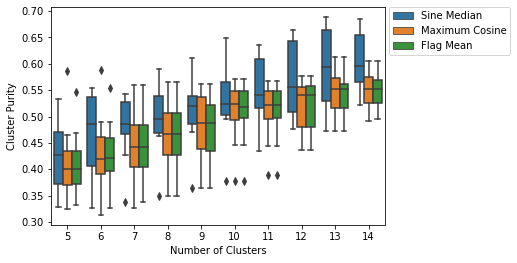

In [ ]:
sns.boxplot(x='Size of Codebook', y='Cluster Purity', hue='Algorithm', data = Purities)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)

In [21]:
dist_sin, dist_cos, dist_flg

([5388.293647807723, 5346.509868147767, 5344.62542093313, 5344.62542093313],
 [35759.9749068364, 34268.02353013004, 34268.02353013004],
 [35759.9749068364, 34255.11915450895, 34255.11915450895])